# PDF to Excel Agent Data Extractor

This notebook extracts agent information from PDF files using OCR (Tesseract) and exports the structured data to an Excel file.

# ⚠️ IMPORTANT USAGE NOTE ⚠️

**This notebook is designed to work EXCLUSIVELY with:**
1. Scanned PDF documents (image-based PDFs)  
2. Documents with a SPECIFIC PAGE LAYOUT (shown below)

## Before Proceeding:

✅ **This notebook WILL WORK PROPERLY if your PDF:**
- Is a scanned document (text is part of the image, not selectable)
- Matches the exact layout structure shown in the reference image below
- Contains agent information in the same format/position

❌ **This notebook WILL NOT WORK PROPERLY if your PDF:**
- Contains native digital text (text you can select/copy)
- Has a different layout than the reference image
- Was created directly from office software (Wose exact positions)*

## How to Verify Your PDF:
1. **Text Selection Test**:
   - Try to select text in your PDF viewer
   - If you **can't** select text → First requirement passed
   - If you **can** select text → Wrong PDF type

2. **Layout Comparison**:
   - Visually compare your document with the reference image
   - Check if agent blocks appear in the same positions
   - Verify field locations (name, firm, address, etc.)

## Consequences of Using Incorrect PDF:
- Complete extraction failure
- Misaligned/missing data fields
- Garbage output in Exquirement AND the layout shown above.**

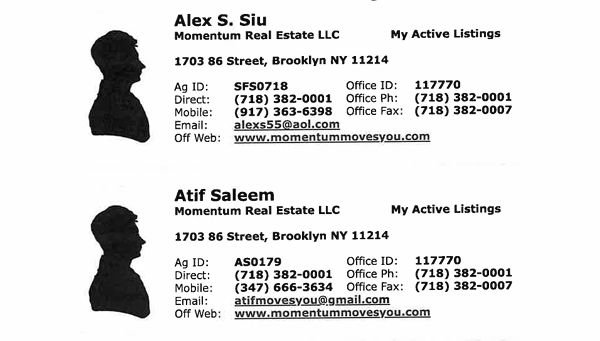

In [22]:
from IPython.display import Image, display
display(Image(filename='Input/reference_layout.png'))

**Do not proceed unless your documents match BOTH the scanned requirement AND the layout shown above.**

## Workflow Overview
1. Install required dependencies
2. Convert PDF pages to images
3. Extract text using OCR
4. Process and structure the extracted data
5. Export to Excel

## 1. Installation and Setup

In [ ]:
# Install required packages (uncomment if needed)
# !pip install pytesseract opencv-python pdf2image pandas pillow

## 2. Import Libraries

In [4]:
import os
from pathlib import Path
import re
import pandas as pd
from PIL import Image
import pytesseract
from pdf2image import convert_from_path

## 3. Configuration

Configure paths and settings:

In [5]:
# Set Tesseract Path (if using Windows)
# Configure Tesseract path (update this to your Tesseract installation path)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [19]:
# Input PDF path (update this to your PDF file location)
pdf_path = 'C:/Users/rocha/OneDrive/Documentos/Python_Scripts/Tesseract/Input/demo_agents.pdf'

# Output directory (will be created if it doesn't exist)
output_dir = '/Users/rocha/OneDrive/Documentos/Python_Scripts/Tesseract/Output/'

# Pages to process (first and last page numbers, 1-based indexing)
first_page_to_convert = 1
last_page_to_convert = 3


## 4. Convert PDF to Images

In [20]:
# Convert PDF pages to images
pages = convert_from_path(pdf_path, first_page=first_page_to_convert, last_page=last_page_to_convert)
print(f"Total pages converted: {len(pages)}")

Total pages converted: 3


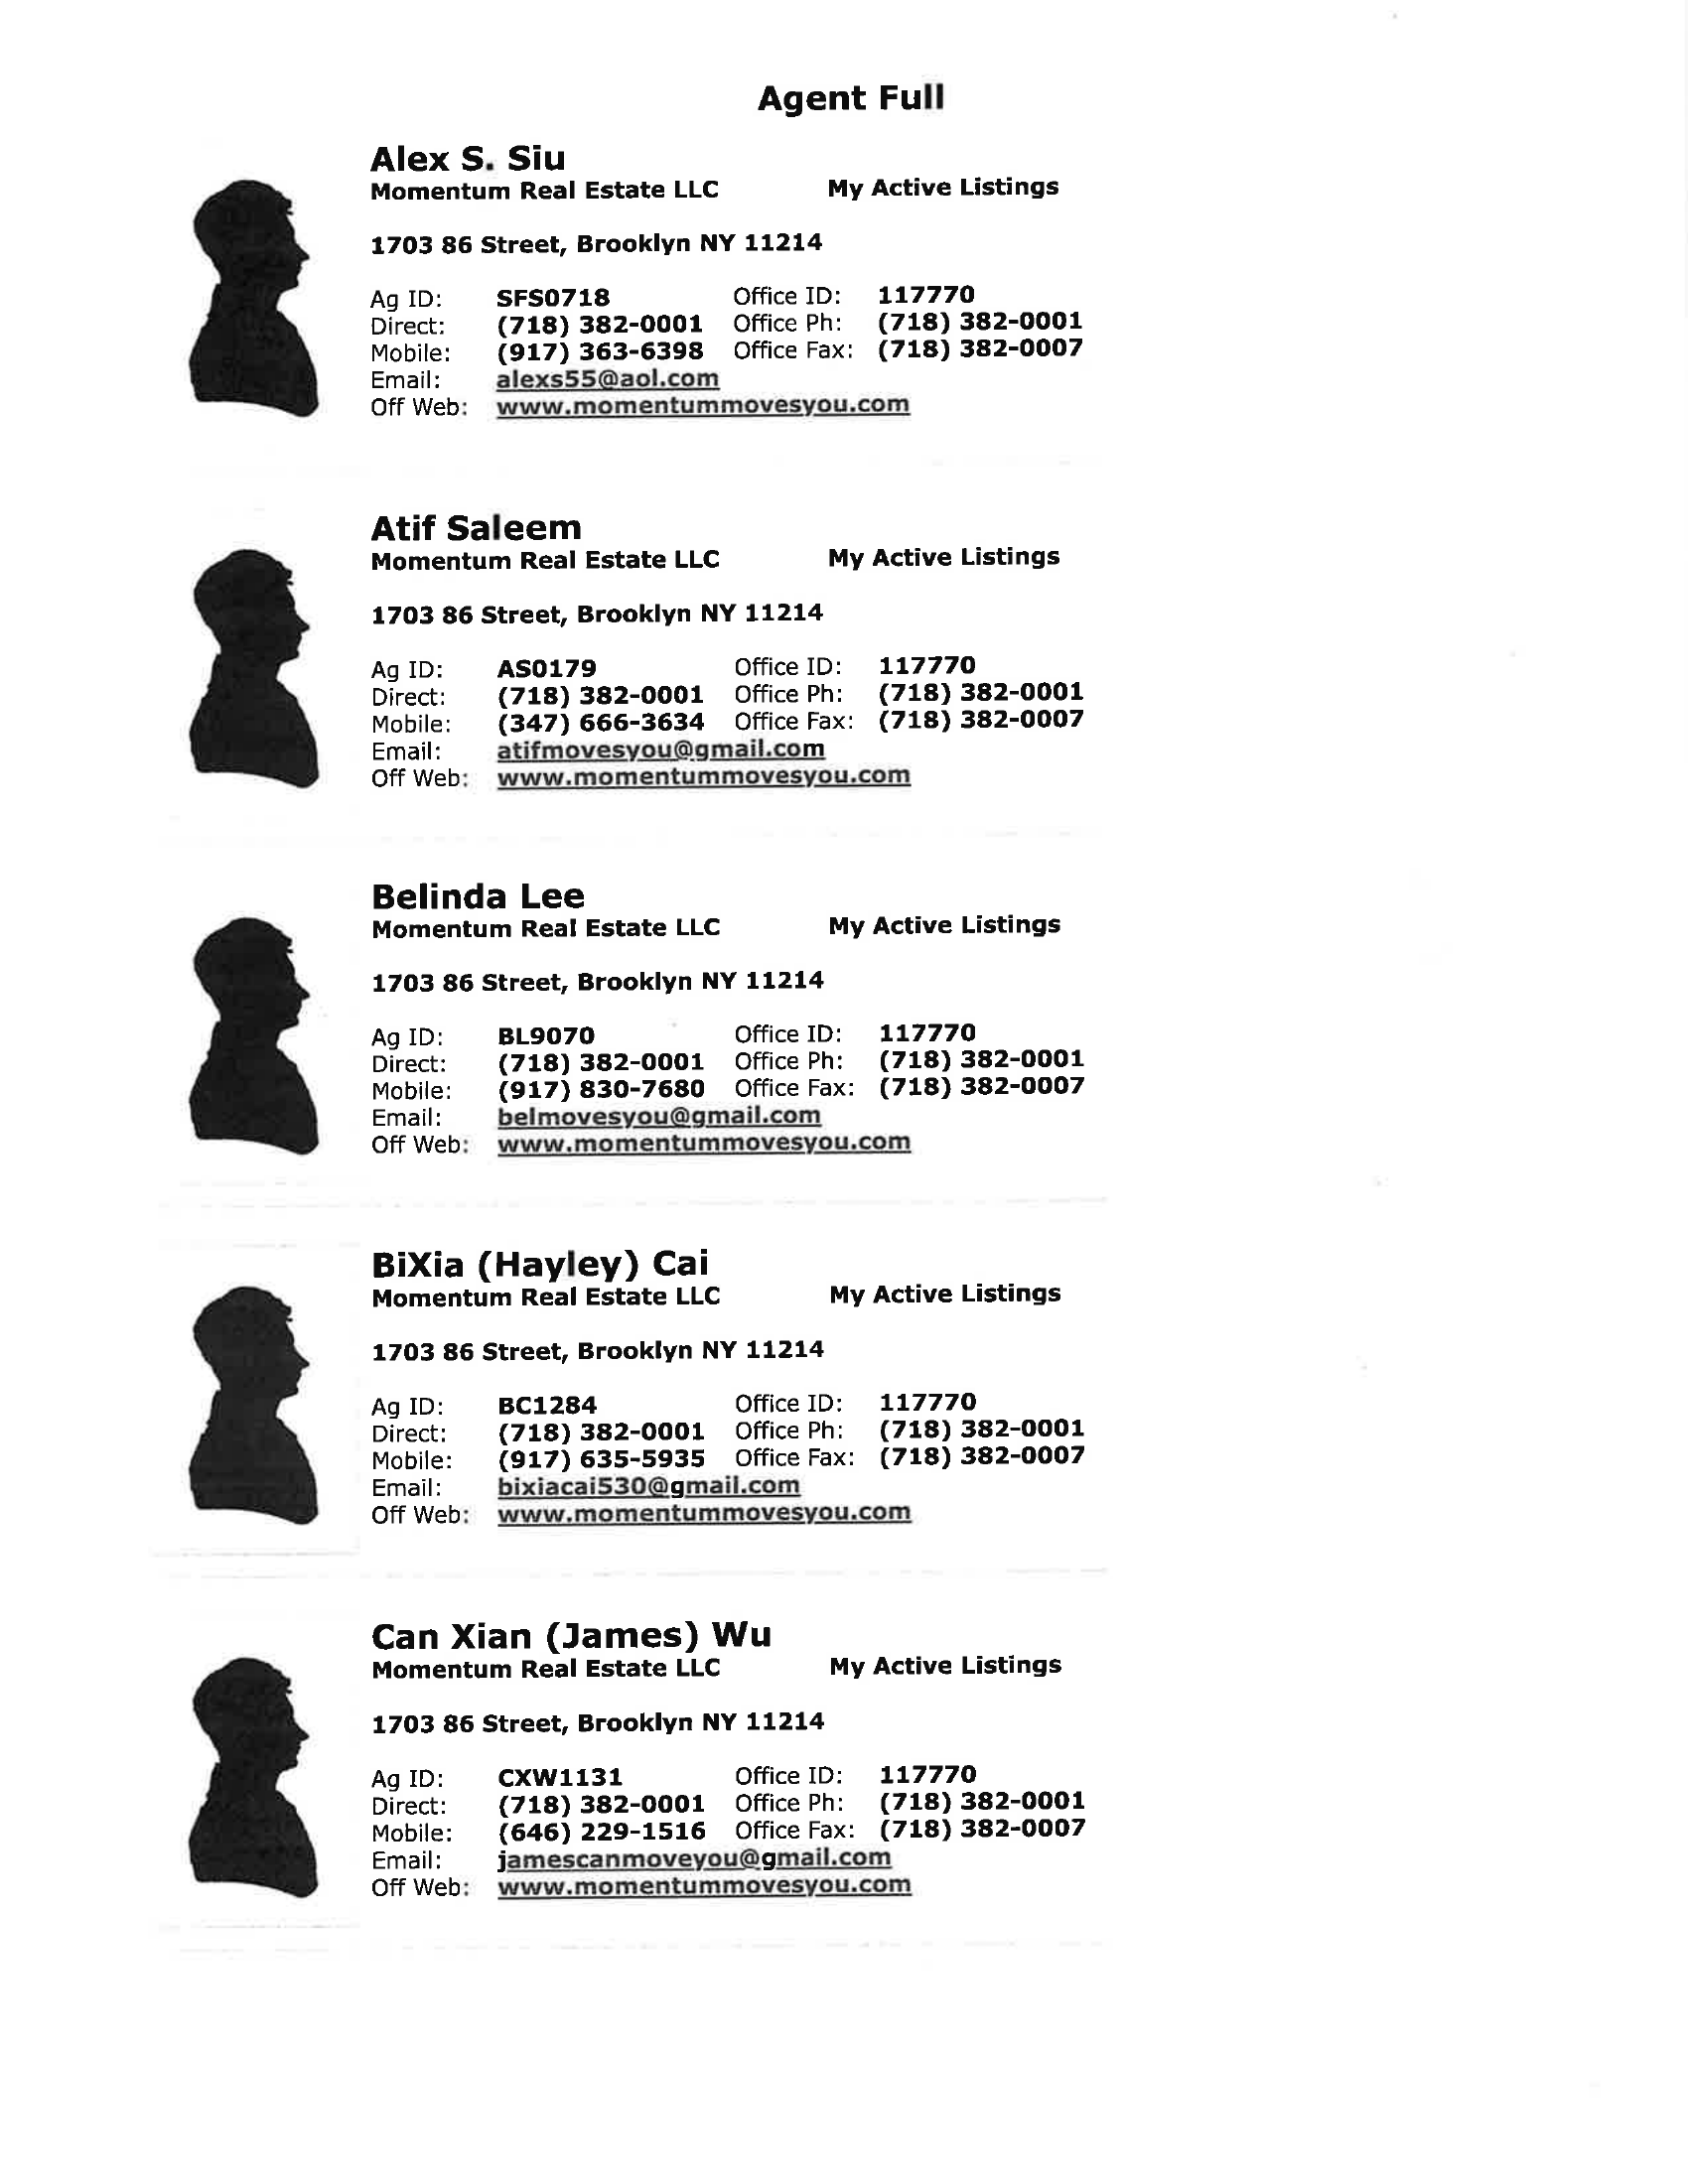

In [21]:
# page 1 image
pages[0]

## 5. Crop and Extract Text from Images

Displaying a cropped section with coordinates: (330, 0, 1700, 2200)


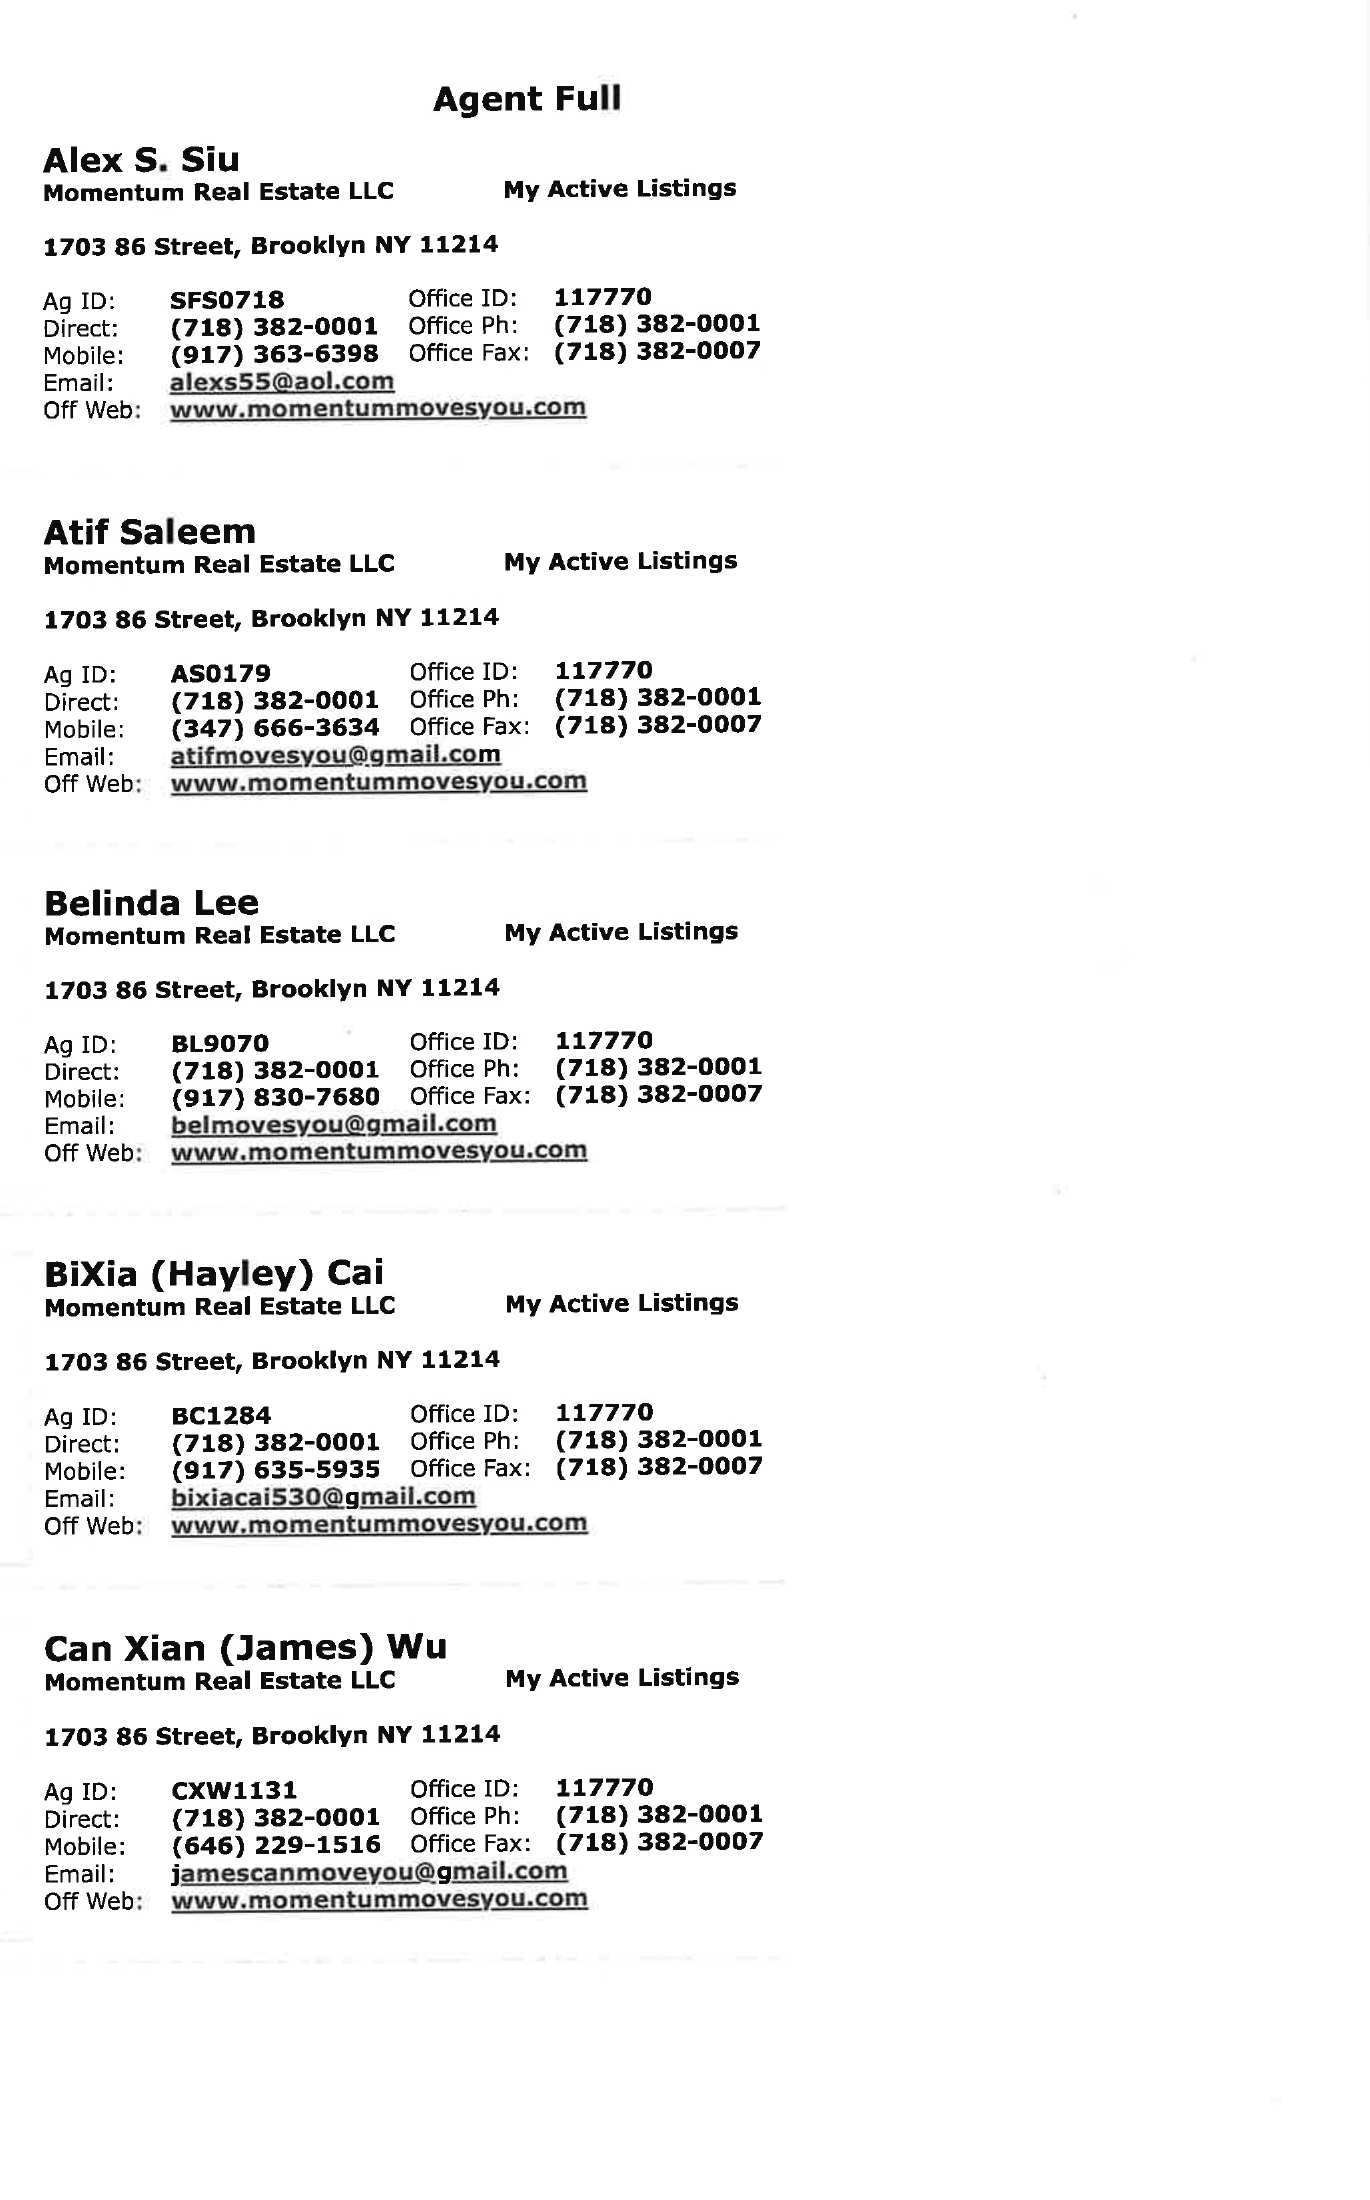

In [11]:
# Crop the image to have onle the text area
area_to_extract = (330, 0, 1700, 2200)  # left, upper, right, lower

# Crop the image
cropped_image = pages[0].crop(area_to_extract)

# Display the cropped image
print(f"Displaying a cropped section with coordinates: {area_to_extract}")
cropped_image

In [12]:
text = ''
for i, page in enumerate(pages, start=first_page_to_convert):
    cropped_page = page.crop(area_to_extract)
    text += pytesseract.image_to_string(cropped_page, lang='eng', config='--psm 6') + '\n'

print(text[:1000])  # Preview the extracted text

Agent Full
Alex S. Siu
Momentum Real Estate LLC My Active Listings
1703 86 Street, Brooklyn NY 11214
Ag ID: SFSO718 Office ID: 117770
Direct: (718) 382-0001 Office Ph: (718) 382-0001
Mobile: (917) 363-6398 Office Fax: (718) 382-0007
Email: alexs55@aol.com
Off Web: www.momentummovesyou.com
Atif Saleem
Momentum Real Estate LLC My Active Listings
1703 86 Street, Brooklyn NY 11214
Ag ID: AS0179 Office ID: 117770
Direct: (718) 382-0001 Office Ph: (718) 382-0001
Mobile: (347) 666-3634 Office Fax: (718) 382-0007
Email: atifmovesyou@gmail.com
Off Web: www.momentummovesyou.com
Belinda Lee
Momentum Real Estate LLC My Active Listings
1703 86 Street, Brooklyn NY 11214
Ag ID: BL9070 Office —ID: 117770
Direct: (718) 382-0001 Office Ph: (718) 382-0001
Mobile: (917) 830-7680 Office Fax: (718) 382-0007
Email: belmovesyou@gmail.com
Off Web: www.momentummovesyou.com
BiXia (Hayley) Cai
Momentum Real Estate LLC My Active Listings
1703 86 Street, Brooklyn NY 11214
Ag ID: BC1284 Office ID: 117770
Direct: (71

## 4. Define Data Extraction Function

In [13]:
def process_agent_data(data_string):
    """
    Processes a multi-agent string to create a list of agent data dictionaries.
    This version relies on the fixed positions of Agent Name, Firm, and Address
    within each agent's block, and keyword-based extraction for other fields.
    The website extraction is now more flexible.
    
    Args:
        data_string (str): The input string containing agent information.
        
    Returns:
        list: A list of dictionaries with structured agent data
    """
    # Regular expressions for field extraction
    direct_phone_pattern = re.compile(r'Direct:\s*(\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})')
    mobile_phone_pattern = re.compile(r'Mobile:\s*(\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})')
    office_ph_pattern = re.compile(r'Office Ph:\s*(\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})')
    office_fax_pattern = re.compile(r'Office Fax:\s*(\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4})')
    email_pattern = re.compile(r'Email:\s*([a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})')
    website_pattern = re.compile(r'Off Web:\s*(https?://(?:www\.)?|[wW]{3}\.)?([a-zA-Z0-9.-]+\.[a-zA-Z]{2,}[^\s]*)')
    
    # Split and clean lines
    lines = data_string.split('\n')
    cleaned_lines = [line.strip() for line in lines if line.strip() and line.strip() != 'Agent Full']

    # Identify agent blocks
    agent_blocks = []
    current_block_lines = []
    name_like_pattern = re.compile(r'^[A-Za-z\s\()\.,-]+$')

    i = 0
    while i < len(cleaned_lines):
        line = cleaned_lines[i]
        
        # Check for new agent block pattern
        if (name_like_pattern.match(line) and
            i + 1 < len(cleaned_lines) and
            not re.search(r'(ID:|Phone|Fax|Web:)', cleaned_lines[i+1]) and
            i + 2 < len(cleaned_lines) and
            not re.search(r'(ID:|Phone|Fax|Web:)', cleaned_lines[i+2])):
            
            if current_block_lines:
                agent_blocks.append(current_block_lines)
            current_block_lines = [line]
        else:
            current_block_lines.append(line)
        i += 1
    
    if current_block_lines:
        agent_blocks.append(current_block_lines)

    # Process each agent block
    table = []
    
    for block_lines in agent_blocks:
        agent_data = {
            'Agent Name': '',
            'Firm': '',
            'Address': '',
            'Agent ID': '',
            'Office ID': '',
            'Direct Phone': '',
            'Mobile': '',
            'Office Phone': '',
            'Office Fax': '',
            'Email': '',
            'Website': ''
        }

        # Get non-empty lines
        non_empty_in_block = [line for line in block_lines if line.strip()]

        # Basic fields (name, firm, address)
        if len(non_empty_in_block) > 0:
            agent_data['Agent Name'] = non_empty_in_block[0]
        if len(non_empty_in_block) > 1:
            agent_data['Firm'] = non_empty_in_block[1].replace(' My Active Listings', '').strip()
        if len(non_empty_in_block) > 2:
            agent_data['Address'] = non_empty_in_block[2]

        # Agent and Office ID
        if len(non_empty_in_block) > 3 and 'ID:' in non_empty_in_block[3]:
            ag_office = non_empty_in_block[3].split('ID:')
            if len(ag_office) > 1:
                agent_data['Agent ID'] = ag_office[1].split()[0].strip()
            if len(ag_office) > 2:
                agent_data['Office ID'] = ag_office[2].strip()

        # Other fields using regex patterns
        block_text = '\n'.join(block_lines)
        
        # Phone numbers and email
        direct_phone_match = direct_phone_pattern.search(block_text)
        if direct_phone_match:
            agent_data['Direct Phone'] = direct_phone_match.group(1).strip()

        mobile_phone_match = mobile_phone_pattern.search(block_text)
        if mobile_phone_match:
            agent_data['Mobile'] = mobile_phone_match.group(1).strip()
        
        office_ph_match = office_ph_pattern.search(block_text)
        if office_ph_match:
            agent_data['Office Phone'] = office_ph_match.group(1).strip()

        office_fax_match = office_fax_pattern.search(block_text)
        if office_fax_match:
            agent_data['Office Fax'] = office_fax_match.group(1).strip()

        email_match = email_pattern.search(block_text)
        if email_match:
            agent_data['Email'] = email_match.group(1).strip()

        # Website extraction
        website_match = website_pattern.search(block_text)
        if website_match:
            prefix = website_match.group(1) if website_match.group(1) else ''
            domain_and_path = website_match.group(2).strip()
            
            if prefix.startswith('www.'):
                agent_data['Website'] = prefix + domain_and_path
            elif prefix:
                agent_data['Website'] = prefix + domain_and_path
            else:
                agent_data['Website'] = website_match.group(0).replace('Off Web:', '').strip()

        table.append(agent_data)
    
    return table

## 5. Process Extracted Text and Display Results

In [14]:
# Process the extracted text
table = process_agent_data(text)
for agent in table[:5]:  # Preview first 5 agents
    for key, value in agent.items():
        print(f"{key}: {value}")

Agent Name: Alex S. Siu
Firm: Momentum Real Estate LLC
Address: 1703 86 Street, Brooklyn NY 11214
Agent ID: SFSO718
Office ID: 117770
Direct Phone: (718) 382-0001
Mobile: (917) 363-6398
Office Phone: (718) 382-0001
Office Fax: (718) 382-0007
Email: alexs55@aol.com
Website: www.momentummovesyou.com
Agent Name: Atif Saleem
Firm: Momentum Real Estate LLC
Address: 1703 86 Street, Brooklyn NY 11214
Agent ID: AS0179
Office ID: 117770
Direct Phone: (718) 382-0001
Mobile: (347) 666-3634
Office Phone: (718) 382-0001
Office Fax: (718) 382-0007
Email: atifmovesyou@gmail.com
Website: www.momentummovesyou.com
Agent Name: Belinda Lee
Firm: Momentum Real Estate LLC
Address: 1703 86 Street, Brooklyn NY 11214
Agent ID: BL9070
Office ID: 117770
Direct Phone: (718) 382-0001
Mobile: (917) 830-7680
Office Phone: (718) 382-0001
Office Fax: (718) 382-0007
Email: belmovesyou@gmail.com
Website: www.momentummovesyou.com
Agent Name: BiXia (Hayley) Cai
Firm: Momentum Real Estate LLC
Address: 1703 86 Street, Brook

In [17]:
# Create DataFrame
df = pd.DataFrame(table, columns=[
    'Agent Name', 'Firm', 'Address', 'Agent ID', 'Office ID',
    'Direct Phone', 'Mobile', 'Office Phone', 'Office Fax',
    'Email', 'Website'
])

# Display first few records
df.head()

,Agent Name,Firm,Address,Agent ID,Office ID,Direct Phone,Mobile,Office Phone,Office Fax,Email,Website
0,Alex S. Siu,Momentum Real Estate LLC,"1703 86 Street, Brooklyn NY 11214",SFSO718,117770,(718) 382-0001,(917) 363-6398,(718) 382-0001,(718) 382-0007,alexs55@aol.com,www.momentummovesyou.com
1,Atif Saleem,Momentum Real Estate LLC,"1703 86 Street, Brooklyn NY 11214",AS0179,117770,(718) 382-0001,(347) 666-3634,(718) 382-0001,(718) 382-0007,atifmovesyou@gmail.com,www.momentummovesyou.com
2,Belinda Lee,Momentum Real Estate LLC,"1703 86 Street, Brooklyn NY 11214",BL9070,117770,(718) 382-0001,(917) 830-7680,(718) 382-0001,(718) 382-0007,belmovesyou@gmail.com,www.momentummovesyou.com
3,BiXia (Hayley) Cai,Momentum Real Estate LLC,"1703 86 Street, Brooklyn NY 11214",BC1284,117770,(718) 382-0001,(917) 635-5935,(718) 382-0001,(718) 382-0007,bixiacai530@gmail.com,www.momentummovesyou.com
4,Can Xian (James) Wu,Momentum Real Estate LLC,"1703 86 Street, Brooklyn NY 11214",cxwii31,117770,(718) 382-0001,(646) 229-1516,,(718) 382-0007,jamescanmoveyou@gmail.com,www.momentummovesyou.com


## 6. Export to Excel

In [18]:
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Generate output filename
output_filename = os.path.join(output_dir, 'agents_export.xlsx')

# Export to Excel
df.to_excel(output_filename, sheet_name='Agent Data', index=False)

print(f"Data successfully exported to: {output_filename}")

Data successfully exported to: /Users/rocha/OneDrive/Documentos/Python_Scripts/Tesseract/Output/agents_export.xlsx


## Notes

1. **Tesseract Installation**: You need to install Tesseract OCR separately on your system:
   - Windows: Download from [UB Mannheim](https://github.com/UB-Mannheim/tesseract/wiki)
   - Mac: `brew install tesseract`
   - Linux: `sudo apt install tesseract-ocr`

2. **PDF Processing**: For large PDFs, consider processing in batches to avoid memory issues.

3. **OCR Accuracy**: The quality of extraction depends on the PDF quality. You may need to adjust the crop area or preprocessing for different PDF formats.